# **Creating Phantoms for K space analysis**


In [ ]:
#Install proper libraries
!pip install --upgrade numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#import matplotlib.animation as animation


from scipy import stats
from scipy.fft import fft2, ifft2, fft, ifft
from scipy.fftpack import fftshift, ifftshift

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

%matplotlib inline 
#%matplotlib notebook

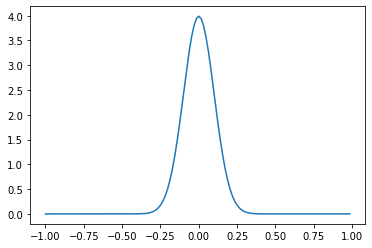

In [ ]:
# Create basis of the image (guassian curve centered around 0.5)
res =  128 #@param {type:'number'}
mean = 0
standard_deviation = 0.1

x_values = np.arange(-1.0, 1.0, 2/res)
y_values = stats.norm.pdf(x_values, mean, standard_deviation) #stats.norm(mean, standard_deviation)
plt.plot(x_values, y_values)


(128, 128)


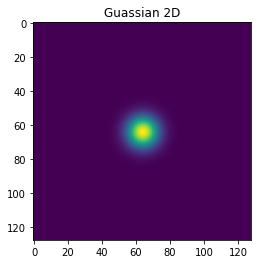

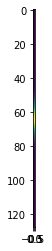

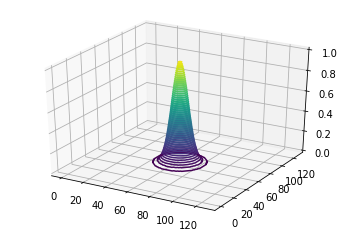

In [ ]:
### Create a 2-D Matrix 
def normalizeData(data, scale=1):
    return (data - np.min(data)) / (scale*(np.max(data) - np.min(data)))

# (100,1) x (1,100) = (100,100) matrix
image = np.matmul(y_values.reshape((-1,1)), y_values.reshape(1,-1))
image = normalizeData(image, 1)
image = np.round(image, 2)

print(image.shape)
plt.figure()
plt.title("Guassian 2D")
plt.imshow(image)
plt.figure()
plt.imshow(image[res//2].reshape(-1,1))
#plt.title(f"Slice {res//2} 1D Representation")
#plt.plot(image[res//2])


def f(x,y):
  return image[x,y]
fig = plt.figure()
ax = plt.axes(projection='3d')
x_step = np.arange(0,res,1)
z = f(x_step,x_step)
ax.contour3D(x_step, x_step, image, 50)

## Fourier Domain Analysis


In [ ]:
"""
USELESS PLOT FUNCTIONS 
"""

def kplot(image):
  plt.figure()
  plt.imshow(np.abs(fftshift(image)))
  #plt.imshow(np.abs(image),cmap='gray')

def iftplot(image, plot = True):
  kspace = ifft2(image)
  if plot:
    kplot(kspace)
  return kspace


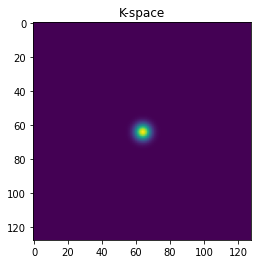

In [ ]:
k_space = ifft2(image)
kplot(k_space)
plt.title("K-space")

#What if I modifiy K_space
#k_space[16,16] = 1
#Kplot(k_space)

#What if I expand k_space by repeating it
def bigger(A):
  return np.vstack((np.hstack((A, A)),np.hstack((A, A))))
#bigger_k = bigger(k_space)
#kplot(bigger_k)

In [ ]:
def roundNormalize(A):
  return np.round(normalizeData(np.abs(A)), 2)

def comparePlot(img1, img2):
  plt.figure()
  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img1)
  ax[1].imshow(img2)

#roundNormalize(reconstruct)

0.0038016602149671154 0.004659952967398957


Text(0.5, 1.0, 'Reconstructed from K_space of Noisy Image + Noise')

<Figure size 432x288 with 0 Axes>

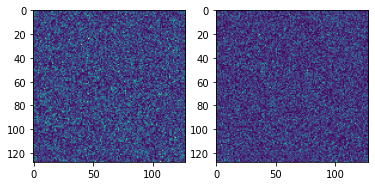

<Figure size 432x288 with 0 Axes>

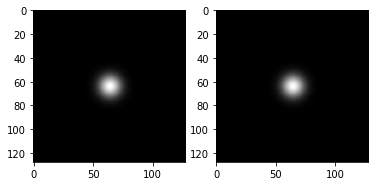

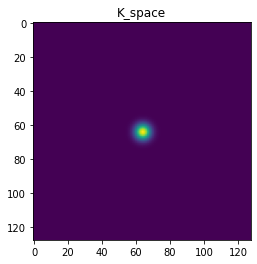

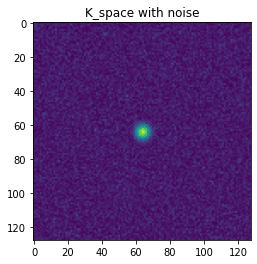

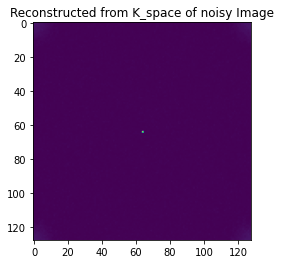

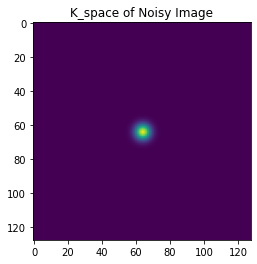

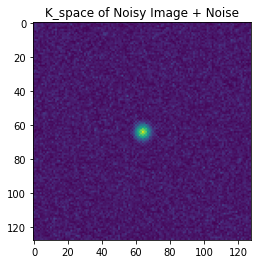

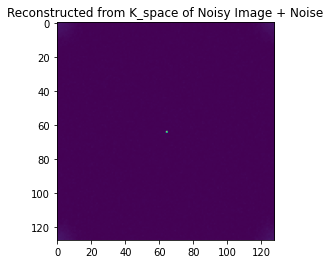

In [ ]:
# Create Noise (both real and complex)
mu = 0
sigma = 0.01 # AccessAccelerated MR thermometry using the Kalman filter Li Zhao1 https://www.researchgate.net/publication/280444884_Accelerated_MR_thermometry_using_the_Kalman_filter
noise_scale = 10 #Based on data normalization, values under 50 make the reconstructed image unobservable

np.random.seed(0)
noise = np.abs(np.random.normal(mu,sigma, (res,res)))/noise_scale
noise_imaginary = np.abs(np.random.normal(mu,sigma, (res,res)))/noise_scale
complex_noise = np.zeros((res,res), dtype=complex)+ noise + (noise_imaginary*1j)

#View Noise
plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].imshow(noise)
ax[1].imshow(noise_imaginary)

print(np.max(noise), np.max(noise_imaginary))
#print(complex_noise)


#View Simulated Image and Kspace
simulated_image = image+complex_noise
plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap="gray")
ax[1].imshow(np.abs(simulated_image), cmap="gray")

#Add noise to K_space of original image
simulated_k = iftplot(image)+complex_noise
plt.title("K_space")
kplot(simulated_k)
plt.title("K_space with noise")
reconstruct_k_noisy = fft2(simulated_k)
kplot(reconstruct_k_noisy)
plt.title("Reconstructed from K_space of noisy Image")

#Add noise to K_space for image with noise
simulated_k = iftplot(simulated_image)+complex_noise
plt.title("K_space of Noisy Image")
kplot(simulated_k)
plt.title("K_space of Noisy Image + Noise")
reconstruct_k_noisy = fft2(simulated_k)
kplot(reconstruct_k_noisy)
plt.title("Reconstructed from K_space of Noisy Image + Noise") 


In [ ]:
#COMPARISONS OF THE MODIFICATIONS TO EITHER IMAGE OR K_SPACE
SSIMrealimg = ssim(image, simulated_image, data_range=image.max()-image.min())      #Compare Noisy Image
SSIMkimg = ssim(k_space, simulated_k, data_range=k_space.max()-k_space.min())       #Compare K_space (Noise added in Original Image)
SSIMknoise = ssim(image, reconstruct_k_noisy)                                       #Compare 

print("Original Image - Simulated Image", SSIMrealimg) 
print("k_space - simulated_k (Image space with noise)", SSIMkimg)                   #NOTE: SSIM ignores complex values
print("Orignal - Reconstruct with modified noisy K space", SSIMknoise)

Original Image - Simulated Image 0.9939561874459248
k_space - simulated_k (Image space with noise) (0.09541754470308544+4.394182596242022e-19j)
Orignal - Reconstruct with modified noisy K space 0.3468189022716278


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  im2 = im2.astype(np.float64)
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:176: ComplexWarning: Casting complex values to real discards the imaginary part
  im1 = im1.astype(np.float64)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  after removing the cwd from sys.path.


# Temperature Effects on MRI Image

Text(0, 0.5, 'Temperature')

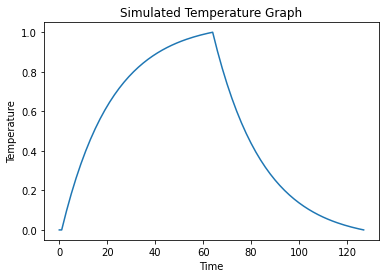

In [ ]:
#CREATE A TIME FUNCTION f(t)
timeframe = 50 #Total 100 => timeframe*2
x = np.linspace(-1, 2, res//2)
y = np.exp(x)

temp_rise = normalizeData(-np.exp(-x))
temp_decend = 1 - normalizeData(-np.exp(-x))[1:]

#plt.figure()
#plt.plot(temp_rise)
#plt.plot(temp_decend)

temp = np.concatenate(([0],temp_rise,temp_decend))
plt.figure()
plt.plot(temp)
plt.title("Simulated Temperature Graph")
plt.xlabel("Time")
plt.ylabel("Temperature")

# Temperature Mapped to the Image Domain

In [ ]:
def createTimeVector(A, temp, slice_id = 1):
  x = A[slice_id,:].reshape(res,-1) #Get slice res//2 (64)

  # Create a vector over time and replace values according to temperature
  for i in range(7):
    x = np.hstack([x,x])
  for i in range(temp.shape[0]):
    x[:,i+1]*=temp[i]

  return x

#plt.imshow(createTimeVector(image, temp, 64))
  

Text(0, 0.5, 'Intensity')

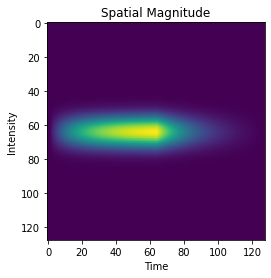

In [ ]:
#Ideal Situation PURE REAL VALUES

# Create a vector over time and replace values according to temperature 
#for i in range(7): #Make 2**7 number of copies
#  x = np.hstack([x,x])
image_time = np.array([image for _ in range(res)])
image_time.shape

for i in range(temp.shape[0]):
  image_time[i,:,:]*=temp[i]

plt.figure()
plt.imshow(image_time[:, res//2, :].transpose())
plt.title("Spatial Magnitude")
plt.xlabel("Time")
plt.ylabel("Intensity")

# Plot the result
#plt.imshow(x, cmap='gray')
#plt.title(f"Slice {res//2}")
#plt.xlabel("Time")
#plt.ylabel("Intensity of XY")


# Recreate K-Space
Note: To simplify the complexity of the problem, the follow will be complete in 1-D (Slice 64 of the orignal Image)

#Why is the fft of a guassian curve sharper, isnt it suppose to be the same?
https://dsp.stackexchange.com/questions/56210/why-does-2d-fft-of-gaussian-looks-more-sharper-than-gaussian-itself

Answer: This is basically the Uncertainty Principle of Fourier Transform.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


Text(0, 0.5, 'Intensity')

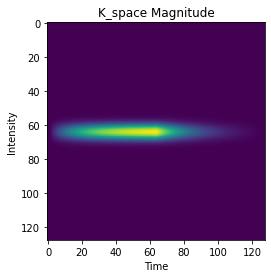

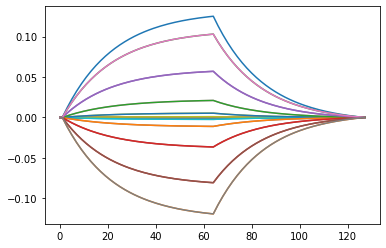

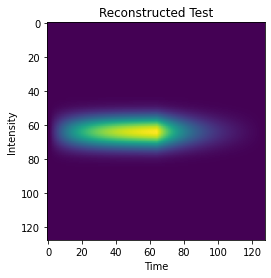

In [ ]:
k_time = ifft(image_time[:,:,res//2]).transpose()#np.array([ifft(image_time[x,64,:]) for x in range(image_time.shape[0])]).transpose()
k_time.shape

plt.figure()
plt.title("K_space Magnitude")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.imshow(np.abs(fftshift(k_time, axes=0)))

plt.figure()
plt.plot(k_time[:,:].transpose())

#Reconstruct
plt.figure()
recon = fft(k_time, axis=0)
plt.imshow(np.abs(recon))
plt.title("Reconstructed Test")
plt.xlabel("Time")
plt.ylabel("Intensity")



#Noise

> Create complex noise and add to image

> Reconstruct to check that the image is correct



2) Undersampling pattern



> Simple (For even time, sample even row. For odd time, sample odd row) 



In [ ]:
def addCNoise(A):
  noise = np.abs(np.random.normal(mu,sigma, A.shape))/1
  noise_imaginary = np.random.normal(mu,sigma, (A.shape))/1
  complex_noise = np.zeros(A.shape, dtype=complex)+ noise + (noise_imaginary*1j)
  #print(np.max(noise), np.max(noise_imaginary), np.min(noise_imaginary))

  return A + complex_noise


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  >>> y = np.require(x, dtype=np.float32, requirements=['A', 'O', 'W', 'F'])


Text(0.5, 0, 'Time')

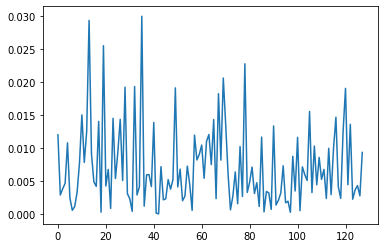

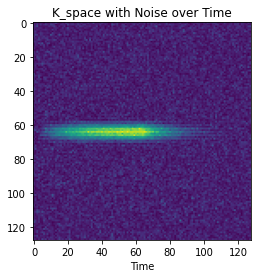

In [ ]:
#Add Noise
#Use the transpose because default stacking from 1D array is horizontal
#     Without transpose, time is row and space is column
k_time_noise = np.array([addCNoise(k_time[:,i]) for i in range(k_time.shape[0])]).transpose()

"""
for i in range(k_time.shape[0]):
  plt.plot(k_time[i,:])
  if i ==10: break
"""
plt.plot(k_time_noise[res//2,:])
#plt.plot(np.abs(k_time[:,64]))

#This recreation took extra steps becuase the shift was different
plt.figure()
#plt.imshow(bigger(np.abs(fftshift(k_time_noise)))[:res,res//2:res//2*3])
plt.imshow(np.abs(fftshift(k_time_noise, axes=0)))
plt.title("K_space with Noise over Time")
plt.xlabel("Time")




Reconstruct from Noisy kspace

Text(0.5, 1.0, 'Reconstructed from Noisy Kspace')

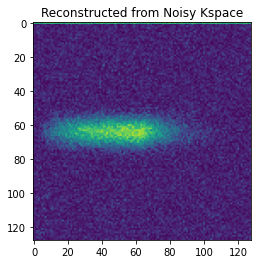

In [ ]:
reconstruct_time = fft(k_time_noise, axis=0) #reconstruct_time = np.array([fft(k_time_noise[:,i]) for i in range(k_time_noise.shape[0])])
plt.imshow(np.abs(reconstruct_time))
plt.title("Reconstructed from Noisy Kspace")


Add Sampling Pattern and view reconstruction

In [ ]:
def evenOddSampling(A):
  """ Undersampling method using even odd sampling based on time
      It will make a checkerboard pattern in matrix
      Example:
      
      [1 1 1       [1 0 1
       1 1 1.  =>   0 1 0
       1 1 1]       1 0 1]
  """
  B = A.copy()
  B[::2,::2] = 0 
  B[1::2,1::2] = 0

  return B


def oddEvenSampling(A):
  """ Undersampling method using even odd sampling based on time
      It will make a checkerboard pattern in matrix
      Example:
      
      [1 1 1       [1 0 1
       1 1 1.  =>   0 1 0
       1 1 1]       1 0 1]
  """
  B = A.copy()
  B[1::2,::2] = 0 
  B[::2,1::2] = 0

  return B

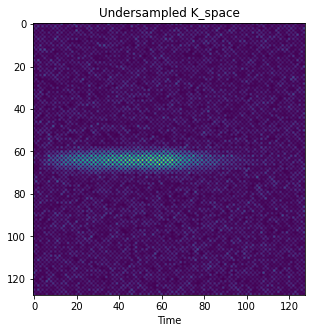

<Figure size 432x288 with 0 Axes>

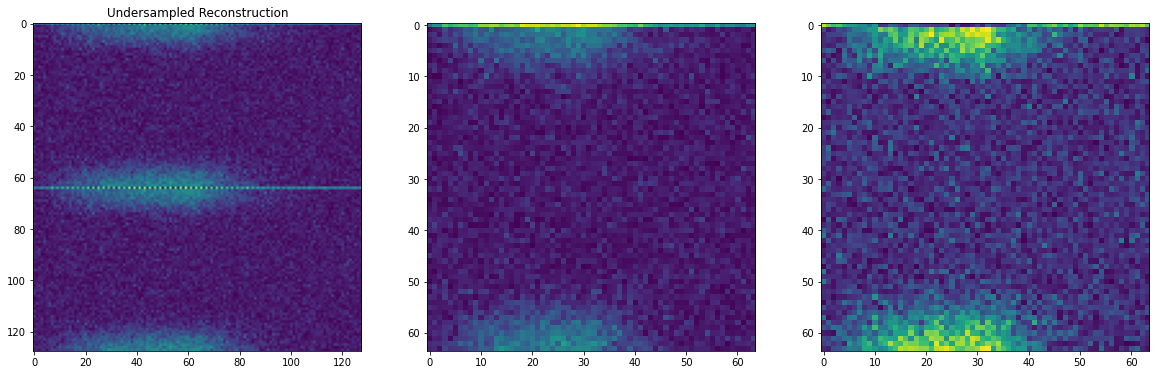

In [ ]:
#Add Sampling
k_time_noise_undersampled = evenOddSampling(k_time_noise)
k_time_noise_undersampled_1 = oddEvenSampling(k_time_noise)

plt.figure(figsize = (5, 5))
#plt.imshow(np.abs(fftshift(k_time_noise_undersampled)))
plt.imshow(bigger(np.abs(fftshift(k_time_noise_undersampled)))[:res,res//2:res//2*3])
plt.title("Undersampled K_space")
plt.xlabel("Time")

recon = fft(k_time_noise_undersampled, axis=0) #reconstruct_time = np.array([fft(k_time_noise[:,i]) for i in range(k_time_noise.shape[0])])
#plt.figure()
#plt.imshow(np.abs(recon))
#plt.title("Reconstructed from Undersampled")

plt.figure()
fig, ax = plt.subplots(1,3, figsize = (20,20))
ax[0].imshow(np.abs(recon))
ax[0].title.set_text("Undersampled Reconstruction")
ax[1].imshow(np.abs(fft(k_time_noise_undersampled[0::2,1::2], axis=0))) #Reconstruct from Even
ax[2].imshow(np.abs(fft(k_time_noise_undersampled[1::2,0::2], axis=0))) #Reconstruct from Odd

Implement View Sharing

Text(0.5, 1.0, 'Reconstructed with View Sharing')

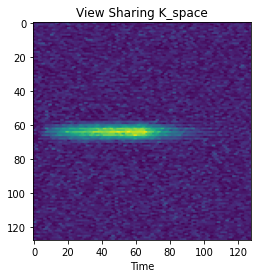

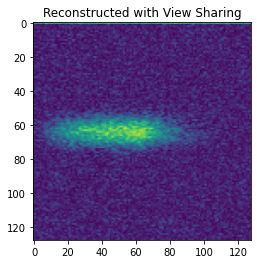

In [ ]:
def viewShare2(A):
  """ Reconstruction method in K-space for evenOddSampling
      Fill in missing data point t with t-1 point
      where 0 represents the missing value
      Input: A size [n,m] where m is the time domain 
      
      Example: 
       t0  t1.    t0  t1
      [1   0.    [1   1
       0   2.     0   2
       3   0 ] => 3   3]
      
      CONTRAINTS of THIS FUNCTION:
        Assumes even odd sampling and will only work 
        with evenOddSampling() function
  """ 
  B = np.zeros((res,res), dtype=complex)
  B[:,0] = A[:,0]
  for i in range(1,A.shape[1]): #Time domain
    #plt.plot(A[:,i])
    B[:,i] = (A[:,i-1]+A[:,i])
    #plt.plot(A[:,i])
    #break
  return B

vsrecon_k = viewShare2(k_time_noise_undersampled)
plt.figure()
#plt.imshow(np.abs(fftshift(k_time_noise_undersampled)))
plt.imshow(bigger(np.abs(fftshift(vsrecon_k)))[:res,res//2:res//2*3])
plt.title("View Sharing K_space")
plt.xlabel("Time")

recon1 = fft(vsrecon_k, axis=0) #reconstruct_time = np.array([fft(k_time_noise[:,i]) for i in range(k_time_noise.shape[0])])
plt.figure()
plt.imshow(np.abs(recon1))
plt.title("Reconstructed with View Sharing")

#**Comparisons**

In [ ]:
#plt.imshow(k_time_noise)

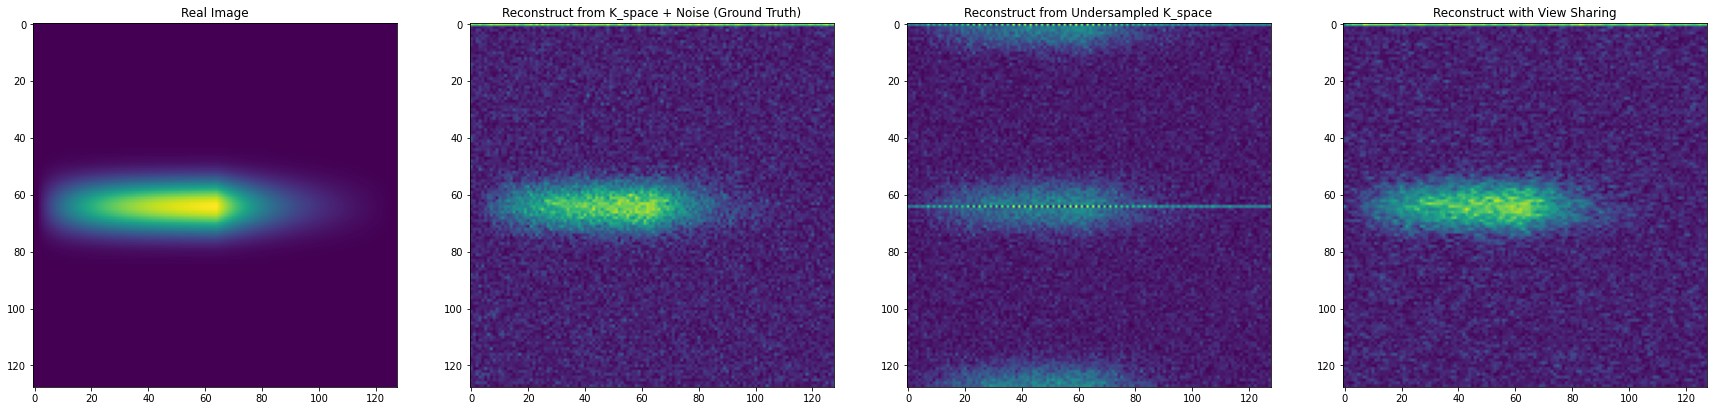

In [ ]:
# Reconstruction Comparisons

fig, ax = plt.subplots(1,4, figsize=(30,30))
ax[0].imshow(image_time[:, res//2, :].transpose())
ax[0].title.set_text('Real Image')
ax[1].imshow(np.abs(reconstruct_time))
ax[1].title.set_text('Reconstruct from K_space + Noise (Ground Truth)')
ax[2].imshow(np.abs(recon))
ax[2].title.set_text('Reconstruct from Undersampled K_space')
ax[3].imshow(np.abs(recon1))
ax[3].title.set_text('Reconstruct with View Sharing')

#Recreate Kalman Filter
 x(k) = x(k-1) + w(k-1)

 z(k) = U(k) F x(k) + v(k)

 where:

> k is the frame (in our case we will say the time for the temperature plot)

> z(k) is the aquired data for that time
 
> F is the fourier transform
 
> U(k) is undersampled 

> w models state changes resulting fromheating




 
 

# ***Neural Network Section***

Goals of this Section


1.   Create a dataset from the simulated data
2.   Create a NN to modeling the temperature curve from the simulated data


Constraints of this Approach

1.   Limited data sample (128 timepoints)
2.   NN will most likely not work on a larger scale due to training data



---


Notes:

Variable 1

> Input:  K_space at time t-1

> Output: K_space at time t

Variable 2

> NN architecture

> 1. CNN (if splitting channel)

> 2. Feed Forward










In [ ]:
#Import for AI (deep learning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [ ]:
def prepareDataCNN(A):
  real_x = np.real(A)
  imag_x = np.imag(A)     
  return np.stack([real_x, imag_x], axis=1) * 100

def perpareDataFCNN(A):
  real_x = np.real(A)
  imag_x = np.imag(A)
  return np.concatenate([real_x, imag_x], axis=0).transpose()*100

Because of nuances of a NN, complex values are difficult to implement therefore the training data must be preprocessed into a data = [sample_set, 2, res] form where n represents the size of the k_space and 2 represents the real and complex value as whole numbers 

In [ ]:
# Prepare Data
# separate real and complex 
#real_x = np.real(k_time_noise_undersampled)
#imag_x = np.imag(k_time_noise_undersampled)
#real_x = np.real(vsrecon_k)
#imag_x = np.imag(vsrecon_k)
x_data = prepareDataCNN(vsrecon_k)#k_time_noise_undersampled) #np.stack([real_x, imag_x], axis=1) * 100

#real_y = np.real(k_time_noise)
#imag_y = np.imag(k_time_noise)
y_data = prepareDataCNN(k_time_noise) #np.stack([real_y, imag_y], axis=1) * 100
 
#plt.imshow(np.abs(vsrecon_k))
#plt.figure(), plt.imshow(x_test[:,:])#x_data[0,:,:])
#plt.figure(), plt.imshow(y_data[0,:,:])
#print(x_data.shape, y_data.shape)
#print(np.max(x_data), np.max(y_data))
y_data.shape

(128, 2, 128)

CNN Method

In [ ]:
#Create CNN models
def CNNmodel():
  a = Input(shape = x_data.shape[1:])
  x = Conv1D(128,2, activation = "relu", padding = "same")(a)
  x = Conv1D(128,2, activation = "relu", padding = "same")(x)
  x = Conv1D(128,2, activation = "relu", padding = "same")(x)
  #x = MaxPool1D(2, padding="same")(x)
  x = Conv1D(128,2, activation = "relu", padding = "same")(x)
  x = Dropout(0.5)(x)
  #x = MaxPooling1D(pool_size=2)(x)
  output = Activation('relu')(x)
  
  cnn = Model(inputs=a, outputs=output)
  # initiate optimizer
  opt = keras.optimizers.Adam(learning_rate=0.001)
  #opt = k.optimizers.Nadam(lr=0.001)
  #opt = keras.optimizers.RMSprop(lr=0.000001, decay=1e-6)
  
  cnn.summary()
  # Let's train the model using RMSprop
  cnn.compile(loss='mse',
                optimizer=opt,
                metrics=['accuracy'])
  return cnn

cnn = CNNmodel()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 128)            32896     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2, 128)            32896     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
activation_4 (Activation)    (None, 2, 128)            0   

In [ ]:
#Train NN modes
history = cnn.fit(x=x_data[:-1,:,:], y=y_data[1:,:,:], epochs=500, batch_size=32)

Epoch 1/500
4/4 [==============================] - 1s 8ms/step - loss: 1.9504 - accuracy: 0.0197
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 1.8785 - accuracy: 0.0079
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 1.8074 - accuracy: 0.0157
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 1.7609 - accuracy: 0.0276
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7203 - accuracy: 0.0157
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 1.7014 - accuracy: 0.0197
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 1.7084 - accuracy: 0.0118
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 1.6757 - accuracy: 0.0315
Epoch 9/500
4/4 [==============================] - 0s 8ms/step - loss: 1.6578 - accuracy: 0.0276
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 1.6495 - accuracy: 0.0157
Epoch 11/500
4/4 [===========

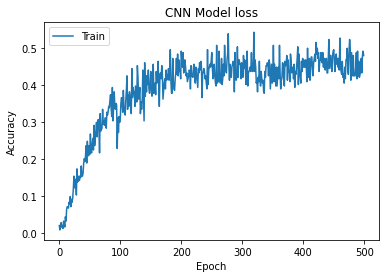

In [ ]:
#Evaluate model based

plt.plot(history.history['accuracy'])

plt.title('CNN Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'test'], loc='upper left')
plt.show()

Text(0.5, 0, 'Time')

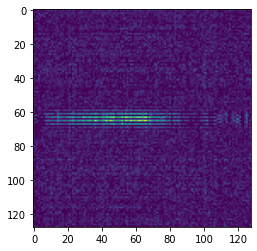

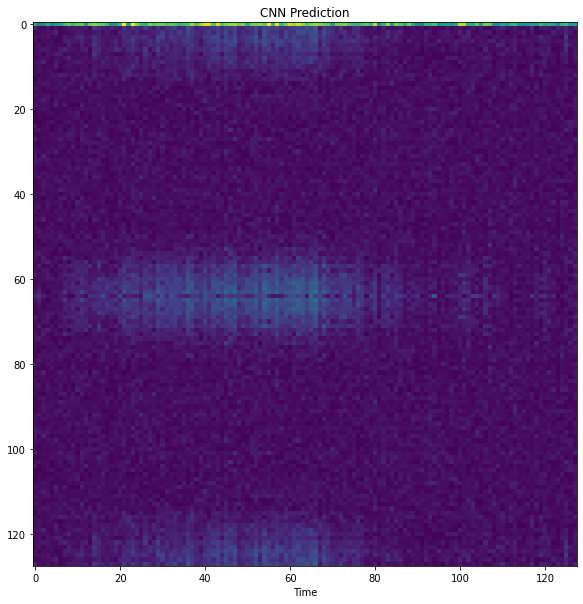

In [ ]:
def remakeComplex(A):
  B = np.zeros((res,res), dtype=complex)
  B = out[:,0,:]#+(out[:,1,:]*1j)
  return B


#real_x = np.real(k_time_noise_undersampled)
#imag_x = np.imag(k_time_noise_undersampled)
#TEST DATA VSRECON2
#real_x = np.real(viewShare2(k_time_noise_undersampled_1))
#imag_x = np.imag(viewShare2(k_time_noise_undersampled_1))
x_test = prepareDataCNN(k_time_noise_undersampled_1)
out = cnn.predict(x_test)
out.shape
#plt.imshow(out[:,0,:])

AIreconK = remakeComplex(out)
#Plot what it looks like in real space
plt.figure(), plt.imshow(fftshift(np.abs(AIreconK), axes=0))
plt.figure(figsize=(10,10))
plt.imshow(np.abs(fft(AIreconK,axis=0)))
plt.title("CNN Prediction")
plt.xlabel("Time")


**CNN Analysis**

Looking at the results, not ideal yet...

Feed Forward NN

Idea: 
> Flatten data to include both real and imaginary on a single axis and use fully connect layers and dropout layers. Then reshape the output at the end and reconstruct the k_space then back to image space


Complex data => separated into real and imaginary matrix, concatenated so the lower rows 0 to n are the real values and n to 2n are imaginary parts 

In [ ]:
#Prepare data for feedforward network
#real_x = np.real(k_time_noise_undersampled)
#imag_x = np.imag(k_time_noise_undersampled)
real_x = np.real(vsrecon_k)
imag_x = np.imag(vsrecon_k)
x_data1 = np.concatenate([real_x, imag_x], axis=0).transpose()

real_y = np.real(k_time_noise)
imag_y = np.imag(k_time_noise)
y_data = np.concatenate([real_x, imag_x], axis=0).transpose()

print(x_data1.shape)

(128, 256)


In [ ]:
def NNmodel():
  a = Input(shape = x_data1.shape[1:])
  x = Dense(res*2, activation='relu')(a)
  x = Dense(res*2, activation='relu')(x)
  x = Dense(res*2, activation='relu')(x)
  x = Dense(res, activation='relu')(x)
  x = Dense(res//2, activation='relu')(x)
  x = Dense(res//4, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(res//8, activation='relu')(x)
  x = Dense(res//4, activation='relu')(x)
  x = Dense(res//2, activation='relu')(x)
  x = Dense(res*2, activation='relu')(x)
  x = Dense(res, activation='relu')(x)
  x = Dense(res*2, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(res*2)(x)
  output = Activation('relu')(x)
  
  cnn = Model(inputs=a, outputs=output)
  # initiate optimizer
  opt = keras.optimizers.Adam(learning_rate=0.001)
  #opt = k.optimizers.Nadam(lr=0.001)
  #opt = keras.optimizers.RMSprop(lr=0.000001, decay=1e-6)
  
  cnn.summary()
  # Let's train the model using RMSprop
  cnn.compile(loss='mse',
                optimizer=opt,
                metrics=['accuracy'])
  return cnn

nn = NNmodel()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
dense_115 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_116 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_117 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_118 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_119 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_120 (Dense)            (None, 32)                208

In [ ]:
#Train NN modes
history = nn.fit(x=x_data1[:-1,:], y=y_data[1:,:], epochs=100, batch_size=8)

Epoch 1/100
16/16 [==============================] - 1s 6ms/step - loss: 1.8202e-04 - accuracy: 0.3543
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 1.5377e-04 - accuracy: 0.4409
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 1.4701e-04 - accuracy: 0.4646
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 1.4186e-04 - accuracy: 0.4961
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 1.3674e-04 - accuracy: 0.5433
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 1.3288e-04 - accuracy: 0.5039
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 1.3115e-04 - accuracy: 0.5276
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 1.2949e-04 - accuracy: 0.5276
Epoch 9/100
16/16 [==============================] - 0s 7ms/step - loss: 1.2875e-04 - accuracy: 0.5276
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss:

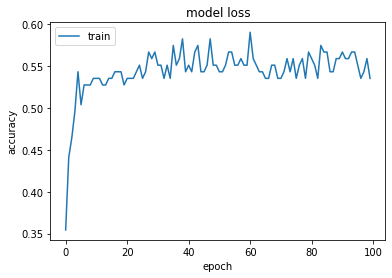

In [ ]:
#Evaluate model based

plt.plot(history.history['accuracy'])

plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 0, 'Time')

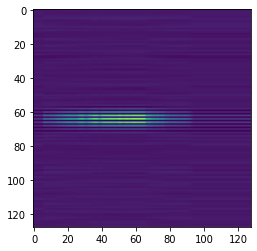

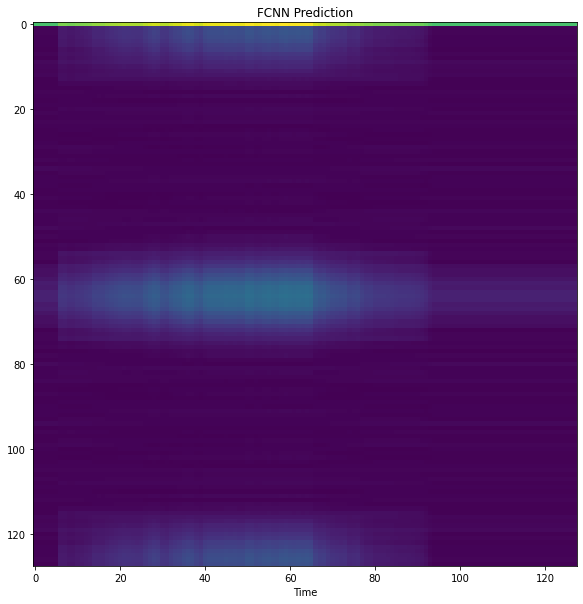

In [ ]:
def remakeComplexFCNN(A):
  B = np.zeros((res,res), dtype=complex)
  real = A[:,:res]
  imag = A[:,res:]
  B = real + (imag* 1j) 
  return B.transpose()

#CREATE TEST DATA HERE------------------------------------------
real_x = np.real(viewShare2(k_time_noise_undersampled_1))
imag_x = np.imag(viewShare2(k_time_noise_undersampled_1))
x_test = np.concatenate([real_x, imag_x], axis=0).transpose()*10

out = nn.predict(x_data1)
AIreconK = remakeComplexFCNN(out)
#Plot what it looks like in real space
plt.figure(), plt.imshow(fftshift(np.abs(AIreconK), axes=0))

plt.figure(figsize=(10,10))
plt.imshow(np.abs(fft(AIreconK,axis=0)))
plt.title("FCNN Prediction")
plt.xlabel("Time")


#RANDOM CODE

In [ ]:
A = np.arange(0,5**2).reshape((5,-1))

print(oddEvenSampling(np.ones((10,10))), "\n\n",
evenOddSampling(np.ones((10,10))))

In [ ]:
""" EXPERIMENTING WITH GOOGLE COLAB ANIMATION (Affects other plt plots, best to avoid for now)
fig, ax = plt.subplots()
ims = []
for i in range(res):
    im = ax.imshow(image_time[i], animated=True)
    if i == 0:
        ax.imshow(image_time[i])# show an initial one first
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

from IPython.display import HTML
HTML(anim.to_html5_video())
"""